In [ ]:
import math
import os
from typing import Dict, List, Sequence, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from obspy import UTCDateTime
from scipy.signal import butter, filtfilt

FS_BY_SENSOR = {"LP": 6.625, "SP": 53.0}


def compute_center_frequencies() -> List[float]:
    """Half-octave centers from 1/16 Hz up to 16*sqrt(2) Hz (inclusive)."""
    return [2.0 ** (k / 2.0) for k in range(-8, 10)]


def load_seismogram_txt(path: str) -> Tuple[np.ndarray, np.ndarray]:
    """Load a seismogram text file as (UTCDateTime array, float64 data)."""
    times: List[UTCDateTime] = []
    data: List[float] = []
    with open(path, "r", encoding="utf-8") as fh:
        fh.readline()  # discard header
        for line in fh:
            parts = line.split()
            if len(parts) < 2:
                continue
            try:
                times.append(UTCDateTime(parts[0]))
                data.append(float(parts[1]))
            except Exception:
                continue
    if len(data) < 2:
        raise RuntimeError(f"Not enough samples in {path}")
    return np.asarray(times, dtype=object), np.asarray(data, dtype=np.float64)


def seconds_since_start(times: Sequence[UTCDateTime]) -> np.ndarray:
    """Convert UTCDateTime sequence to relative seconds."""
    t0 = times[0]
    return np.array([t - t0 for t in times], dtype=np.float64)


def butter_bandpass_filter(
    data: np.ndarray,
    fs: float,
    lowcut: float,
    highcut: float,
    order: int = 4,
) -> np.ndarray:
    """Apply zero-phase Butterworth band-pass if within Nyquist limits."""
    nyquist = 0.5 * fs
    if lowcut <= 0 or highcut >= nyquist:
        raise ValueError("Band is outside valid Nyquist limits")
    wn = [lowcut / nyquist, highcut / nyquist]
    b, a = butter(order, wn, btype="bandpass")
    return filtfilt(b, a, data)


def rolling_average_time(times: np.ndarray, values: np.ndarray, window: int) -> Tuple[np.ndarray, np.ndarray]:
    """Apply rolling average over a window of samples."""
    if len(times) < window:
        return None, None
    time_rolled, val_rolled = [], []
    for i in range(len(values) - window + 1):
        twindow = times[i : i + window]
        vwindow = values[i : i + window]
        time_rolled.append(np.mean(twindow))
        val_rolled.append(np.mean(vwindow))
    return np.array(time_rolled), np.array(val_rolled)


def write_filtered_trace(
    path: str,
    times: Sequence[UTCDateTime],
    filtered: np.ndarray,
) -> None:
    """Persist filtered trace as text (ISO time, amplitude)."""
    with open(path, "w", encoding="utf-8") as fh:
        fh.write("time amplitude\n")
        for t, amp in zip(times, filtered):
            fh.write(f"{t.isoformat()} {amp:.6e}\n")


def sensor_channel_map(station: str) -> Dict[str, List[str]]:
    """Return sensor/channel mapping per station per requirements."""
    if station == "S12":
        return {"LP": ["MHZ"]}
    if station == "S14":
        return {"SP": ["SHZ"]}
    return {"LP": ["MHZ"], "SP": ["SHZ"]}


def normalize_for_plot(trace: np.ndarray) -> np.ndarray:
    """Normalize a trace to +/-0.4 for stacking."""
    max_amp = float(np.max(np.abs(trace)))
    if max_amp <= 0:
        return np.zeros_like(trace)
    return 2 * trace / max_amp


def plot_filter_bank_overview(
    plot_data: Dict[str, Tuple[np.ndarray, List[Tuple[float, np.ndarray]]]],
    station: str,
    event_time_str: str,
    seismo_dir: str,
) -> None:
    """Create and display the 1x2 LP/SP overview filter bank figure."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    sensors = ["LP", "SP"]

    for ax, sensor in zip(axes, sensors):
        entry = plot_data.get(sensor)
        ax.set_title(f"{sensor} filter bank")
        ax.set_xlabel("Time since event start (min)")

        if not entry:
            ax.text(0.5, 0.5, "No data", ha="center", va="center", fontsize=12)
            continue

        time_sec, filtered_list = entry
        x_minutes = time_sec / 60.0
        num_traces = len(filtered_list)
        cmap = plt.cm.get_cmap("turbo", num_traces)
        y_positions = np.arange(num_traces)

        for idx, (center, trace) in enumerate(filtered_list):
            trace_section = trace
            normalized = normalize_for_plot(trace_section)
            ax.plot(
                x_minutes,
                normalized + y_positions[idx],
                color=cmap(idx),
                #label=f"{center:.1f} Hz",
                linewidth=0.8,
            )
        

        ax.set_yticks(y_positions)
        ax.set_xlim(15, 80) 
        ax.set_yticklabels([
            f"1/{round(1/center, 1)}" if center < 1.0 else f"{center:.1f}"
            for center, _ in filtered_list
        ])
        ax.set_ylabel("Center frequency (Hz)")
        ax.legend(loc="upper right", fontsize=8, ncol=1)

    fig.suptitle(
        f"{station} {event_time_str} – Half-octave filter bank (Butterworth order 4)",
        fontsize=13,
    )
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    plot_path = os.path.join(seismo_dir, f"filter_bank_plot_{station}_{event_time_str}.png")
    plt.savefig(plot_path, dpi=300, bbox_inches="tight")
    plt.close(fig)  # Close the figure to free memory
    print(f"Saved filter bank plot to {plot_path}")


def compute_band_limited_noise_power(
    noise_csv_path: str,
    low: float,
    high: float,
) -> float:
    """Calculate band-limited mean power by integrating one-sided PSD."""
    try:
        df = pd.read_csv(noise_csv_path)
        freq = df['frequency'].to_numpy()
        psd = df['psd_du'].to_numpy()
        
        # Ensure PSD is one-sided (positive frequencies only)
        mask = (freq >= 0) & (freq >= low) & (freq <= high)
        if not np.any(mask):
            raise ValueError("No data within the specified frequency band")
        
        freq_band = freq[mask]
        psd_band = psd[mask]
        
        # Integrate PSD over the frequency band using trapezoidal rule
        power = np.trapz(psd_band, freq_band)
        if power <= 0:
            raise ValueError("Computed power is non-positive")
        return power
    except Exception as exc:
        raise ValueError(f"Failed to compute band-limited noise power: {exc}")


def process_event(
    station: str,
    event_time_str: str,
    base_dir: str,
    verbose: bool = True,
) -> Dict[str, List[float]]:
    """Load LP/SP data for an event, run filter bank with noise normalization, and display overview plot."""
    centers = compute_center_frequencies()
    results: Dict[str, List[float]] = {}
    sensor_map = sensor_channel_map(station)
    plot_data: Dict[str, Tuple[np.ndarray, List[Tuple[float, np.ndarray]]]] = {}
    noise_base_dir = "/Users/yanyuzhang/Documents/Python/noise_convert/DU"

    for sensor, channels in sensor_map.items():
        for channel in channels:
            fs = FS_BY_SENSOR.get(sensor)
            if fs is None:
                if verbose:
                    print(f"No sampling rate known for sensor {sensor}; skipping.")
                continue

            seismo_dir = os.path.join(
                base_dir, station, sensor, event_time_str, channel
            )
            seismo_path = os.path.join(seismo_dir, "seismogram.txt")
            key = f"{sensor}_{channel}"

            # Construct noise CSV path based on station and channel
            noise_csv = f"{station}_{channel}.csv"
            noise_path = os.path.join(noise_base_dir, noise_csv)

            if not os.path.exists(seismo_path):
                if verbose:
                    print(f"Missing seismogram for {key} at {seismo_path}")
                continue

            try:
                times, data = load_seismogram_txt(seismo_path)
            except Exception as exc:  # noqa: BLE001
                if verbose:
                    print(f"Failed to load {key}: {exc}")
                continue

            time_sec = seconds_since_start(times)
            nyquist = 0.5 * fs
            filtered_data: List[Tuple[float, np.ndarray]] = []
            if verbose:
                print(f"Processing {key} (fs={fs:.3f} Hz, Nyquist={nyquist:.3f} Hz)")

            for center in centers:
                low = center / math.sqrt(2.0)
                high = center * math.sqrt(2.0)
                if high >= nyquist or low <= 0:
                    if verbose:
                        print(
                            f"  Skipping {center:.3f} Hz for {key}; "
                            f"band [{low:.3f}, {high:.3f}] outside Nyquist."
                        )
                    continue
                try:
                    filtered = butter_bandpass_filter(data, fs, low, high)
                    # Square the filtered seismogram to make amplitudes positive
                    filtered = filtered ** 2
                    # Apply rolling average with a 30-second window
                    window_samples = int(30 * fs)  # Convert 30 seconds to samples
                    smoothed_times_sec, smoothed_filtered = rolling_average_time(
                        time_sec, filtered, window_samples
                    )
                    if smoothed_times_sec is None or smoothed_filtered is None:
                        if verbose:
                            print(
                                f"  Skipping {center:.3f} Hz for {key}; "
                                f"not enough samples for 30s rolling average."
                            )
                        continue
                    # Load noise PSD and compute band-limited power
                    noise_power = compute_band_limited_noise_power(noise_path, low, high)
                    # Normalize by N^2 (square of band-limited noise power)
                    normalized_filtered = smoothed_filtered / noise_power
                    # Convert smoothed times back to UTCDateTime for storage
                    smoothed_times = np.array([times[0] + t for t in smoothed_times_sec])
                except ValueError as exc:
                    if verbose:
                        print(
                            f"  Skipping {center:.3f} Hz for {key}; "
                            f"filter design or noise normalization failed: {exc}"
                        )
                    continue

                filtered_data.append((center, normalized_filtered))
                # Use fractional format for center < 1.0, otherwise standard format
                if center < 1.0:
                    reciprocal = 1.0 / center
                    center_label = f"1_{round(reciprocal, 1)}"
                else:
                    center_label = f"{center:.1f}"
                out_txt = os.path.join(seismo_dir, f"seismogram_{center_label}.txt")
                write_filtered_trace(out_txt, smoothed_times, normalized_filtered)
                if verbose:
                    print(
                        f"  Saved band {center:.3f} Hz to "
                        f"`seismogram_{center_label}.txt`"
                    )

            if filtered_data:
                results[key] = [center for center, _ in filtered_data]
                plot_data[sensor] = (smoothed_times_sec, filtered_data)  # Use smoothed times
            else:
                if verbose:
                    print(f"No valid filter bands for {key}")

    if plot_data:
        plot_filter_bank_overview(plot_data, station, event_time_str, seismo_dir)

    return results


def get_all_stations_and_events(base_dir: str) -> List[Tuple[str, str]]:
    """Scan base directory for all stations and their event subdirectories."""
    station_event_pairs = []
    for station in os.listdir(base_dir):
        if station not in ["S15", "S16"]:
            continue
        station_path = os.path.join(base_dir, station)
        if not os.path.isdir(station_path):
            continue
        for sensor in ["LP", "SP"]:
            sensor_path = os.path.join(station_path, sensor)
            if not os.path.isdir(sensor_path):
                continue
            for event_time_str in os.listdir(sensor_path):
                event_path = os.path.join(sensor_path, event_time_str)
                if os.path.isdir(event_path):
                    station_event_pairs.append((station, event_time_str))
    return sorted(list(set(station_event_pairs)))  # Remove duplicates and sort


def main() -> None:
    base_dir = "Located_impacts"
    station_event_pairs = get_all_stations_and_events(base_dir)
    
    if not station_event_pairs:
        print("No stations or events found in the base directory.")
        return

    print(f"Processing {len(station_event_pairs)} station-event pairs...")
    for station, event_time_str in station_event_pairs:
        print(f"\nProcessing station {station}, event {event_time_str}")
        summary = process_event(
            station=station,
            event_time_str=event_time_str,
            base_dir=base_dir,
            verbose=True,
        )
        if summary:
            print(f"\nFilter bank results for {station} {event_time_str}:")
            for key, bands in summary.items():
                formatted = ", ".join(f"{c:.3f}" for c in bands)
                print(f"  {key}: {formatted}")
        else:
            print(f"No filtered outputs produced for {station} {event_time_str}")


if __name__ == "__main__":
    main()

Processing 67 station-event pairs...

Processing station S15, event 19711020T180800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipping 2.828 Hz for LP_MHZ; band [2.000, 4.000] outside Nyquist.
  Skipping 4.000 Hz for LP_MHZ; band [2.828, 5.657] outside Nyquist.
  Skipping 5.657 Hz for LP_MHZ; band [4.000, 8.000] outside Nyquist.
  Skipping 8.000 Hz for LP_MHZ; band [5.657, 11.314] outside Nyquist.
  Skipping 11.314 Hz for LP_MHZ; band [8.000, 16.000] outside Nyq

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19711020T180800/SHZ/filter_bank_plot_S15_19711020T180800.png

Filter bank results for S15 19711020T180800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720104T063500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19720104T063500/SHZ/filter_bank_plot_S15_19720104T063500.png

Filter bank results for S15 19720104T063500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720513T084600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19720513T084600/SHZ/filter_bank_plot_S15_19720513T084600.png

Filter bank results for S15 19720513T084600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720717T215600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19720717T215600/SHZ/filter_bank_plot_S15_19720717T215600.png

Filter bank results for S15 19720717T215600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720731T180800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19720731T180800/SHZ/filter_bank_plot_S15_19720731T180800.png

Filter bank results for S15 19720731T180800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720829T225900
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19720829T225900/SHZ/filter_bank_plot_S15_19720829T225900.png

Filter bank results for S15 19720829T225900:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19720921T004800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19720921T004800/SHZ/filter_bank_plot_S15_19720921T004800.png

Filter bank results for S15 19720921T004800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19721119T182400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19721119T182400/SHZ/filter_bank_plot_S15_19721119T182400.png

Filter bank results for S15 19721119T182400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19721202T075800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19721202T075800/SHZ/filter_bank_plot_S15_19721202T075800.png

Filter bank results for S15 19721202T075800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19730423T135600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19730423T135600/SHZ/filter_bank_plot_S15_19730423T135600.png

Filter bank results for S15 19730423T135600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19730704T024600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19730704T024600/SHZ/filter_bank_plot_S15_19730704T024600.png

Filter bank results for S15 19730704T024600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19730801T110200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19730801T110200/SHZ/filter_bank_plot_S15_19730801T110200.png

Filter bank results for S15 19730801T110200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19730926T204800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19730926T204800/SHZ/filter_bank_plot_S15_19730926T204800.png

Filter bank results for S15 19730926T204800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19731021T053200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19731021T053200/SHZ/filter_bank_plot_S15_19731021T053200.png

Filter bank results for S15 19731021T053200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19731224T100500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19731224T100500/SHZ/filter_bank_plot_S15_19731224T100500.png

Filter bank results for S15 19731224T100500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19740419T183400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19740419T183400/SHZ/filter_bank_plot_S15_19740419T183400.png

Filter bank results for S15 19740419T183400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19740630T174500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19740630T174500/SHZ/filter_bank_plot_S15_19740630T174500.png

Filter bank results for S15 19740630T174500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19740706T141400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19740706T141400/SHZ/filter_bank_plot_S15_19740706T141400.png

Filter bank results for S15 19740706T141400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19740717T120500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19740717T120500/SHZ/filter_bank_plot_S15_19740717T120500.png

Filter bank results for S15 19740717T120500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19740923T115300
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19740923T115300/SHZ/filter_bank_plot_S15_19740923T115300.png

Filter bank results for S15 19740923T115300:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19741121T131600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19741121T131600/SHZ/filter_bank_plot_S15_19741121T131600.png

Filter bank results for S15 19741121T131600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19741209T093000
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19741209T093000/SHZ/filter_bank_plot_S15_19741209T093000.png

Filter bank results for S15 19741209T093000:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19741215T090800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19741215T090800/SHZ/filter_bank_plot_S15_19741215T090800.png

Filter bank results for S15 19741215T090800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19750301T041800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19750301T041800/SHZ/filter_bank_plot_S15_19750301T041800.png

Filter bank results for S15 19750301T041800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19750305T215200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19750305T215200/SHZ/filter_bank_plot_S15_19750305T215200.png

Filter bank results for S15 19750305T215200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19750412T181500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19750412T181500/SHZ/filter_bank_plot_S15_19750412T181500.png

Filter bank results for S15 19750412T181500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19750504T100500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19750504T100500/SHZ/filter_bank_plot_S15_19750504T100500.png

Filter bank results for S15 19750504T100500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19751006T125800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19751006T125800/SHZ/filter_bank_plot_S15_19751006T125800.png

Filter bank results for S15 19751006T125800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19760113T071400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S15/SP/19760113T071400/SHZ/filter_bank_plot_S15_19760113T071400.png

Filter bank results for S15 19760113T071400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19760125T161000
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19760125T161000/SHZ/filter_bank_plot_S15_19760125T161000.png

Filter bank results for S15 19760125T161000:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19760516T124800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19760516T124800/SHZ/filter_bank_plot_S15_19760516T124800.png

Filter bank results for S15 19760516T124800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19761114T231600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19761114T231600/SHZ/filter_bank_plot_S15_19761114T231600.png

Filter bank results for S15 19761114T231600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19770417T233500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19770417T233500/SHZ/filter_bank_plot_S15_19770417T233500.png

Filter bank results for S15 19770417T233500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S15, event 19770628T222500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S15/SP/19770628T222500/SHZ/filter_bank_plot_S15_19770628T222500.png

Filter bank results for S15 19770628T222500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19720513T084600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19720513T084600/SHZ/filter_bank_plot_S16_19720513T084600.png

Filter bank results for S16 19720513T084600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19720717T215600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19720717T215600/SHZ/filter_bank_plot_S16_19720717T215600.png

Filter bank results for S16 19720717T215600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19720731T180800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19720731T180800/SHZ/filter_bank_plot_S16_19720731T180800.png

Filter bank results for S16 19720731T180800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19720829T225900
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19720829T225900/SHZ/filter_bank_plot_S16_19720829T225900.png

Filter bank results for S16 19720829T225900:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19720921T004800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19720921T004800/SHZ/filter_bank_plot_S16_19720921T004800.png

Filter bank results for S16 19720921T004800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19721114T192500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19721114T192500/SHZ/filter_bank_plot_S16_19721114T192500.png

Filter bank results for S16 19721114T192500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19721119T182400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19721119T182400/SHZ/filter_bank_plot_S16_19721119T182400.png

Filter bank results for S16 19721119T182400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19721202T075800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19721202T075800/SHZ/filter_bank_plot_S16_19721202T075800.png

Filter bank results for S16 19721202T075800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19730423T135600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19730423T135600/SHZ/filter_bank_plot_S16_19730423T135600.png

Filter bank results for S16 19730423T135600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19730704T024600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19730704T024600/SHZ/filter_bank_plot_S16_19730704T024600.png

Filter bank results for S16 19730704T024600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19730801T110200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19730801T110200/SHZ/filter_bank_plot_S16_19730801T110200.png

Filter bank results for S16 19730801T110200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19730926T204800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19730926T204800/SHZ/filter_bank_plot_S16_19730926T204800.png

Filter bank results for S16 19730926T204800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19731021T053200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19731021T053200/SHZ/filter_bank_plot_S16_19731021T053200.png

Filter bank results for S16 19731021T053200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19731224T100500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19731224T100500/SHZ/filter_bank_plot_S16_19731224T100500.png

Filter bank results for S16 19731224T100500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19740419T183400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19740419T183400/SHZ/filter_bank_plot_S16_19740419T183400.png

Filter bank results for S16 19740419T183400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19740630T174500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19740630T174500/SHZ/filter_bank_plot_S16_19740630T174500.png

Filter bank results for S16 19740630T174500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19740706T141400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19740706T141400/SHZ/filter_bank_plot_S16_19740706T141400.png

Filter bank results for S16 19740706T141400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19740717T120500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19740717T120500/SHZ/filter_bank_plot_S16_19740717T120500.png

Filter bank results for S16 19740717T120500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19740923T115300
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19740923T115300/SHZ/filter_bank_plot_S16_19740923T115300.png

Filter bank results for S16 19740923T115300:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19741121T131600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19741121T131600/SHZ/filter_bank_plot_S16_19741121T131600.png

Filter bank results for S16 19741121T131600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19741209T093000
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19741209T093000/SHZ/filter_bank_plot_S16_19741209T093000.png

Filter bank results for S16 19741209T093000:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19741215T090800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19741215T090800/SHZ/filter_bank_plot_S16_19741215T090800.png

Filter bank results for S16 19741215T090800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19750301T041800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19750301T041800/SHZ/filter_bank_plot_S16_19750301T041800.png

Filter bank results for S16 19750301T041800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19750305T215200
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19750305T215200/SHZ/filter_bank_plot_S16_19750305T215200.png

Filter bank results for S16 19750305T215200:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19750412T181500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19750412T181500/SHZ/filter_bank_plot_S16_19750412T181500.png

Filter bank results for S16 19750412T181500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19750504T100500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19750504T100500/SHZ/filter_bank_plot_S16_19750504T100500.png

Filter bank results for S16 19750504T100500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19751006T125800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19751006T125800/SHZ/filter_bank_plot_S16_19751006T125800.png

Filter bank results for S16 19751006T125800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19760113T071400
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no ar

  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.
Saved filter bank plot to Located_impacts/S16/SP/19760113T071400/SHZ/filter_bank_plot_S16_19760113T071400.png

Filter bank results for S16 19760113T071400:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19760125T161000
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to 

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19760125T161000/SHZ/filter_bank_plot_S16_19760125T161000.png

Filter bank results for S16 19760125T161000:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19760516T124800
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19760516T124800/SHZ/filter_bank_plot_S16_19760516T124800.png

Filter bank results for S16 19760516T124800:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19761114T231600
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19761114T231600/SHZ/filter_bank_plot_S16_19761114T231600.png

Filter bank results for S16 19761114T231600:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19770417T233500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19770417T233500/SHZ/filter_bank_plot_S16_19770417T233500.png

Filter bank results for S16 19770417T233500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000

Processing station S16, event 19770628T222500
Processing LP_MHZ (fs=6.625 Hz, Nyquist=3.312 Hz)
  Saved band 0.062 Hz to `seismogram_1_16.0.txt`
  Saved band 0.088 Hz to `seismogram_1_11.3.txt`
  Saved band 0.125 Hz to `seismogram_1_8.0.txt`
  Saved band 0.177 Hz to `seismogram_1_5.7.txt`
  Saved band 0.250 Hz to `seismogram_1_4.0.txt`
  Saved band 0.354 Hz to `seismogram_1_2.8.txt`
  Saved band 0.500 Hz to `seismogram_1_2.0.txt`
  Saved band 0.707 Hz to `seismogram_1_1.4.txt`
  Saved band 1.000 Hz to `seismogram_1.0.txt`
  Saved band 1.414 Hz to `seismogram_1.4.txt`
  Saved band 2.000 Hz to `seismogram_2.0.txt`
  Skipp

/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


  Saved band 16.000 Hz to `seismogram_16.0.txt`
  Skipping 22.627 Hz for SP_SHZ; band [16.000, 32.000] outside Nyquist.


/var/folders/6c/rybd089s7ssd_ybsnsgsxvd40000gp/T/ipykernel_21079/2562075403.py:125: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("turbo", num_traces)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Saved filter bank plot to Located_impacts/S16/SP/19770628T222500/SHZ/filter_bank_plot_S16_19770628T222500.png

Filter bank results for S16 19770628T222500:
  LP_MHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000
  SP_SHZ: 0.062, 0.088, 0.125, 0.177, 0.250, 0.354, 0.500, 0.707, 1.000, 1.414, 2.000, 2.828, 4.000, 5.657, 8.000, 11.314, 16.000


: 

In [12]:
import pandas as pd
import numpy as np

# Define the Haversine formula to calculate distance between two lat/lon points
def haversine(lat1, lon1, lat2, lon2):
    # Moon's radius in kilometers
    R = 1737.4
    
    # Convert latitude and longitude from degrees to radians
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # Differences in coordinates
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    distance = R * c
    
    return distance

data = pd.read_csv("Located_Impacts.csv")

# Station coordinates
stations = {
    'S12': {'lat': -3.0099, 'lon': 336.5752},
    'S14': {'lat': -3.64408, 'lon': 342.52233},
    'S15': {'lat': 26.13411, 'lon': 3.62980},
    'S16': {'lat': -8.9759, 'lon': 15.4986}
}

# Normalize longitudes to [-180, 180] range
data['Longitude (deg)'] = (data['Longitude (deg)'] + 180) % 360 - 180
for station in stations:
    stations[station]['lon'] = (stations[station]['lon'] + 180) % 360 - 180

# Calculate distances for each station and add as new columns
for station, coords in stations.items():
    data[f'distance_{station}'] = haversine(
        data['Latitude (deg)'], data['Longitude (deg)'],
        coords['lat'], coords['lon']
    )

# Save the updated DataFrame to a new CSV file
data.to_csv('Located_impacts.csv', index=False)

# Print the first few rows to verify
print(data.head())

   ID        Date (UTC)  Latitude (deg)  Longitude (deg)  \
0   1  1971/05/12 09:34           -18.9             -5.9   
1   2  1971/05/23 22:09             1.7            -16.6   
2   3  1971/06/27 18:44            57.0            129.4   
3   4  1971/07/27 11:34             7.8            -21.9   
4   5  1971/10/20 17:57            36.1            -36.9   

   Momentum mv (kg m/s)  Tau τ (s)  distance_S12  distance_S14  distance_S15  \
0             8180000.0       0.50    708.762593    575.978206   1394.135384   
1            24800000.0       0.45    251.389016    164.219114    947.035606   
2            71100000.0       0.70   3695.289418   3655.944992   2583.687222   
3             3490000.0       0.60    331.022070    371.919329    922.245129   
4            38900000.0       0.70   1245.862914   1324.995758   1086.157913   

   distance_S16  
0    696.938508  
1   1022.491631  
2   3348.147051  
3   1239.128537  
4   2023.516801  


Saved: /Users/yanyuzhang/Documents/Python/Lunar_Impact_Map_with_Apollo_Stations.png


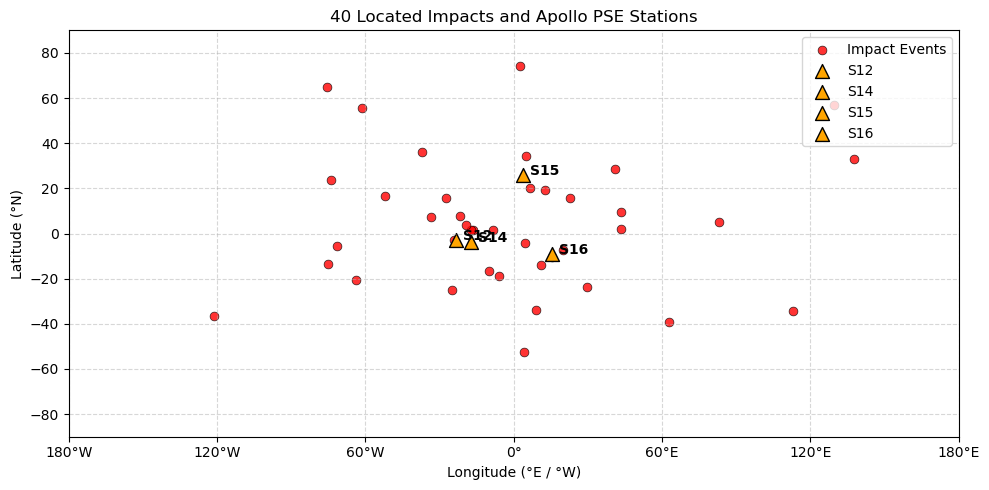

In [20]:
#import argparse
import os
import pandas as pd
import matplotlib.pyplot as plt

APOLLO_STATIONS = {
    'S12': {'lat': -3.0099,  'lon': 336.5752},
    'S14': {'lat': -3.64408, 'lon': 342.52233},
    'S15': {'lat': 26.13411, 'lon': 3.62980},
    'S16': {'lat': -8.9759,  'lon': 15.4986},
}

def load_events(csv_path: str) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    # Normalize longitudes to [0, 360)
    if "Longitude (deg)" not in df.columns or "Latitude (deg)" not in df.columns:
        raise ValueError("CSV must contain columns 'Longitude (deg)' and 'Latitude (deg)'.")
    df["Longitude (deg)"] = df["Longitude (deg)"] % 360
    return df

def normalize_longitude(lon):
    """
    Convert longitude from 0–360°E to -180–+180° (E/W convention).
    0° = central meridian, positive east, negative west.
    """
    lon = ((lon + 180) % 360) - 180
    return lon

def plot_lunar_map(df: pd.DataFrame, out_png: str = "Lunar_Impact_Map_EW.png"):
    plt.figure(figsize=(10, 5))

    # Plot impact events
    plt.scatter(
        normalize_longitude(df["Longitude (deg)"]), df["Latitude (deg)"],
        s=40, alpha=0.8, color='red', edgecolors='black', linewidths=0.5,
        label="Impact Events"
    )

    # Plot Apollo stations
    for name, coord in APOLLO_STATIONS.items():
        lon = normalize_longitude(coord['lon'])
        lat = coord['lat']
        plt.scatter(lon, lat, marker='^', s=100, edgecolors='black', color='orange', label=name)
        plt.text(lon + 3, lat, name, fontsize=10, weight='bold', color='black')

    # Map aesthetics
    plt.title("40 Located Impacts and Apollo PSE Stations")
    plt.xlabel("Longitude (°E / °W)")
    plt.ylabel("Latitude (°N)")
    plt.xlim(-180, 180)
    plt.ylim(-90, 90)
    plt.xticks(range(-180, 181, 60),
               [f"{abs(x)}°W" if x < 0 else ("0°" if x == 0 else f"{x}°E") for x in range(-180, 181, 60)])
    plt.grid(True, linestyle='--', alpha=0.5)

    # Legend (deduplicated)
    handles, labels = plt.gca().get_legend_handles_labels()
    unique = dict(zip(labels, handles))
    plt.legend(unique.values(), unique.keys(), loc="upper right", frameon=True)

    plt.tight_layout()
    plt.savefig(out_png, dpi=300, bbox_inches="tight")
    print(f"Saved: {os.path.abspath(out_png)}")

def main():
    #parser = argparse.ArgumentParser(description="Plot lunar impact locations and Apollo stations.")
    #parser.add_argument(
    #    "--csv",
    #    default="Table1_Meteoroid_Impacts.csv",
    #    help="Path to the Table 1 CSV file (default: Table1_Meteoroid_Impacts.csv)",
    #)
    #parser.add_argument(
    #    "--out",
    #    default="Lunar_Impact_Map_with_Apollo_Stations.png",
    #    help="Output PNG filename (default: Lunar_Impact_Map_with_Apollo_Stations.png)",
    #)
    #args = parser.parse_args()

    df = load_events("Located_Impacts.csv")
    plot_lunar_map(df, "Lunar_Impact_Map_with_Apollo_Stations.png")

if __name__ == "__main__":
    main()
